In [1]:
import pandas as pd 
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt 
#import lightgbm as lgb
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from datetime import timedelta
from pandas import pivot_table

In [2]:
raw_df = pd.read_csv('rosbank_train.csv',error_bad_lines=False)
raw_df.head(5)
test = pd.read_csv('test.csv',error_bad_lines=False)

b'Skipping line 62159: expected 10 fields, saw 11\n'
b'Skipping line 77247: expected 10 fields, saw 15\nSkipping line 92925: expected 10 fields, saw 13\n'
b'Skipping line 138168: expected 10 fields, saw 12\n'
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1,2,4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [547]:
test1 = pd.read_csv('test.csv',error_bad_lines=False)

In [548]:
test1= test1.loc[:,'cl_id']

In [550]:
qqq=test1.drop_duplicates()

In [3]:
test['target_flag'] = 'p'
test['target_sum'] = 'p'

In [4]:
frames = [raw_df, test]

In [5]:
raw_df = pd.concat(frames)

In [6]:
raw_df = raw_df[raw_df['amount'] != 'POS']
raw_df = raw_df[raw_df['MCC'] != 'type1']
raw_df = raw_df[raw_df['cl_id'] != '21MAR17:00:00:00']
raw_df = raw_df[raw_df['cl_id'] != ':00:00:00']
raw_df = raw_df[raw_df['TRDATETIME'] != 'POS']
raw_df = raw_df[raw_df['TRDATETIME'] != '02JUL174.0']
raw_df = raw_df[raw_df['PERIOD'] != '017']

In [7]:
raw_df['amount'] = raw_df['amount'].astype('float')
raw_df['cl_id'] = raw_df['cl_id'].astype('int')
raw_df['trx_category'] = raw_df['trx_category'].astype('str')

In [8]:
from datetime import datetime, date, time
# Creating separate cols for yr, month,...
raw_df['Year'] = raw_df.TRDATETIME.str[5:7]
raw_df['Month'] = raw_df.TRDATETIME.str[2:5]
raw_df['Date'] = raw_df.TRDATETIME.str[0:2]
raw_df['Hour'] = raw_df.TRDATETIME.str[8:10]
# Replace month with ints
raw_df.Month = raw_df.Month.replace(to_replace=['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN','JUL','AUG','SEP','OCT','NOV','DEC' ], value=[1,2,3,4,5,6,7,8,9,10,11,12])


raw_df = raw_df.drop(np.where(raw_df['Year'] == '')[0])
raw_df = raw_df.drop(np.where(raw_df['Date'] == '69')[0])
raw_df = raw_df.drop(np.where(raw_df.Month == '90.')[0])
raw_df = raw_df.loc[raw_df['Month'] != '551']
raw_df = raw_df.loc[raw_df['Month'] != '90.']

In [9]:
raw_df.Year = raw_df.Year.apply(pd.to_numeric)
raw_df.Date = raw_df.Date.apply(pd.to_numeric)
raw_df.Month= raw_df.Month.apply(pd.to_numeric)
raw_df.Hour = raw_df.Hour.apply(pd.to_numeric)
raw_df.Year = raw_df.Year + 2000

In [10]:
def to_day(row):    
    return date(row[10],row[11],row[12]).weekday()
raw_df['day'] = raw_df.apply(to_day, axis=1)

In [11]:
def to_date(row):    
    return date(row[10],row[11],row[12])
raw_df['DateFormat'] = raw_df.apply(to_date, axis=1)

In [12]:
def weekday(raw):
    if raw['day'] == 0:
        return 'Mon'
    if raw['day'] == 1:
        return 'Tue'
    if raw['day'] == 2:
        return 'Wed'
    if raw['day'] == 3:
        return 'Thu'
    if raw['day'] == 4:
        return 'Fri'
    if raw['day'] == 5:
        return 'Sat'
    if raw['day'] == 6:
        return 'Sun'
    
    
raw_df['Day1'] = raw_df.apply(weekday, axis=1)    
   
#date.fromordinal(int(raw_df['DateFormat'].apply(lambda x: x.toordinal()).mean()))

In [13]:
#raw_df.to_excel('new2.xlsx', startrow=3, index=True)

In [14]:
raw_df["TRDATETIME"] = pd.to_datetime(raw_df.TRDATETIME, format='%d%b%y:%H:%M:%S')
#test["TRDATETIME"] = pd.to_datetime(test.TRDATETIME, format='%d%b%y:%H:%M:%S')

raw_df['month'] = raw_df['TRDATETIME'].dt.month + (raw_df['TRDATETIME'].dt.year-2016)*12
#test['month'] = test['TRDATETIME'].dt.month + (test['TRDATETIME'].dt.year-2016)*12

raw_df['days_since2015'] = (raw_df['TRDATETIME'] - pd.to_datetime('2015-01-01')).dt.days
#test['days_since2015'] = (test['TRDATETIME'] - pd.to_datetime('2015-01-01')).dt.days

In [15]:
def operations1(raw):
    if raw['trx_category'] == 'POS':
        return raw['amount']*(-1)
    if raw['trx_category'] == 'C2C_OUT':
        return raw['amount']*(-1)
    if raw['trx_category'] == 'WD_ATM_PARTNER':
        return raw['amount']*(-1)
    if raw['trx_category'] == 'WD_ATM_ROS':
        return raw['amount']*(-1)    
    else:
        return raw['amount']
raw_df['corrected_am1'] = raw_df.apply(operations1, axis=1)

# DAYS IN USAGE

In [36]:
pos= raw_df[raw_df['trx_category']=='POS']

In [37]:
last_day_pos = pos[['TRDATETIME', 'cl_id']].groupby('cl_id').agg('max')
first_day_pos = pos[['TRDATETIME', 'cl_id']].groupby('cl_id').agg('min')
last_day_pos=last_day_pos.reset_index()
first_day_pos=first_day_pos.reset_index()
days_in_use_pos= pd.merge(last_day_pos, first_day_pos, 'left', on=['cl_id'])
days_in_use_pos['time_pos'] = days_in_use_pos['TRDATETIME_x'] - days_in_use_pos['TRDATETIME_y']

In [38]:
last_day = raw_df[['TRDATETIME', 'cl_id']].groupby('cl_id').agg('max')
first_day = raw_df[['TRDATETIME', 'cl_id']].groupby('cl_id').agg('min')
last_day=last_day.reset_index()
first_day=first_day.reset_index()
days_in_use= pd.merge(last_day, first_day, 'left', on=['cl_id'])
days_in_use['time_pos'] = days_in_use['TRDATETIME_x'] - days_in_use['TRDATETIME_y']

In [39]:
month_of_take = raw_df[['PERIOD', 'cl_id']].groupby('cl_id').agg('min').reset_index()

In [40]:
last_day = raw_df[['TRDATETIME', 'cl_id']].groupby('cl_id').agg('max')
#temp =  all_data[['TRDATETIME', 'cl_id']].groupby('cl_id').agg('max').reset_index()

In [41]:
first_day = raw_df[['TRDATETIME', 'cl_id']].groupby('cl_id').agg('min')

In [42]:
last_day=last_day.reset_index()
first_day=first_day.reset_index()

In [43]:
days_in_use= pd.merge(last_day, first_day, 'left', on=['cl_id'])

raw_df['corrected_am1'] = raw_df.apply(operations1, axis=1)

In [44]:
days_in_use['time'] = days_in_use['TRDATETIME_x'] - days_in_use['TRDATETIME_y']

In [45]:
usage= pd.merge(days_in_use, month_of_take,  'left', on=['cl_id'])

In [59]:
usage2 = usage.merge( days_in_use_pos, 'left', on='cl_id')

In [61]:
# make new variable - last action minus n days 
delta_cols = []
for i in [7, 14, 30, 60]:
    new_col = 'last_action_minus_'+str(i)+'_days'
    delta_cols.append(new_col)
    usage2[new_col] = usage2['TRDATETIME_x_y'] - timedelta(days=i)

In [52]:
#usage2['qwe']=usage2.time_pos_y.astype(str)

In [63]:
#newone = pd.merge(raw_df, usage2, 'left', on=['cl_id'])
newone = raw_df.merge(usage2, 'left', on=['cl_id'])

In [80]:
#newone.to_csv('newone.csv', startrow=3, index=True)
newone.to_csv('newone.csv',index=False)

del usage['TRDATETIME_x_x']
del usage['TRDATETIME_y_x']
del usage['TRDATETIME_x_y']
del usage['TRDATETIME_y_y']

In [75]:
def am_7_days(raw):
    if raw['TRDATETIME'] >= raw['last_action_minus_7_days']:
        return raw['corrected_am1']
newone['7_days']=newone.apply(am_7_days,axis=1)


def am_60_days(raw):
    if raw['TRDATETIME'] >= raw['last_action_minus_60_days']:
        return raw['corrected_am1']
newone['60_days']=newone.apply(am_60_days,axis=1)


def am_1_month(raw):
    if raw['TRDATETIME'] <= raw['last_action_minus_60_days']:
        return raw['corrected_am1']
newone['1_month']=newone.apply(am_1_month,axis=1)


def am_2_month(raw):
    if raw['last_action_minus_60_days'] < raw['TRDATETIME'] < raw['last_action_minus_30_days' ]:
        return raw['corrected_am1']
newone['2_month']=newone.apply(am_2_month,axis=1)


def am_3_month(raw):
    if raw['TRDATETIME'] >= raw['last_action_minus_30_days']:
        return raw['corrected_am1']
newone['3_month']=newone.apply(am_3_month,axis=1)

In [68]:
def empy_montes_max(x):
    return np.max(np.diff(np.unique(x)))

sum_deals = newone[['cl_id','days_since2015']].groupby('cl_id').agg(empy_montes_max).reset_index()
sum_deals.columns = ['cl_id','empy_days_max']
newone = pd.merge(newone, sum_deals, how='left', on='cl_id')

In [ ]:
deliv_cards['PERIOD'] = pd.to_datetime(raw_df['PERIOD'], format='%d/%m/%Y')

In [ ]:
deliv_cards

In [ ]:
def uniq_len(x):
    return len(set(x))

deliv_cards = raw_df[['cl_id','PERIOD']].groupby('PERIOD').agg(['count',uniq_len]).reset_index()

In [ ]:
deliv_cards

In [ ]:
asd=raw_df[raw_df['PERIOD']=='01/01/2017']

In [ ]:
dsa=raw_df.groupby('cl_id').agg('count').reset_index()

In [82]:
copy = newone.copy()

In [20]:
copy.trx_category.unique()

array(['POS', 'DEPOSIT', 'C2C_OUT', 'WD_ATM_ROS', 'BACK_TRX',
       'WD_ATM_PARTNER', 'WD_ATM_OTHER', 'C2C_IN', 'CAT', 'CASH_ADV'],
      dtype=object)

In [21]:
del copy['TRDATETIME']
del copy['Year']
del copy['Month']
del copy['Date']
del copy['Hour']
del copy['day']
copy['day'] = copy['Day1']
del copy['Day1']

# MCC CODES

In [83]:
copy.channel_type = copy.channel_type.fillna('F')

copy.amount = copy.amount.fillna(0)

raw_df1=raw_df.reset_index()

In [84]:
copy.MCC = copy.MCC.astype(int)

In [85]:
mcc_codes = pd.read_excel('mcc_codes1.xlsx')
mcc_codes.columns = ['MCC', 'Name' , 'Group']

In [86]:
merged = pd.merge(copy, mcc_codes, 'left', on=['MCC'])

In [87]:
merged.currency=merged.currency.astype(int)

In [88]:
regions = pd.read_excel('regions.xlsx')

In [89]:
regions.currency=regions.currency.astype(int)

In [90]:
update = merged.merge(regions, 'left', on=['currency'])

update = update.loc[update['amount'] != 'POS']
update.amount = update.amount.astype(float)

In [91]:
def amount_in_ruble(row):
    return row['corrected_am1'] * row['exchange']
update['amount_in_rub'] = update.apply(amount_in_ruble, axis=1)
update.amount_in_rub =update.amount_in_rub.astype(int)

In [92]:
del update['amount']

In [93]:
def cashback(raw):
    if raw['trx_category'] == 'POS':
        return raw['amount_in_rub']*0.07
update['cashback'] = update.apply(cashback, axis=1)

update['Group'].unique()

update[update['Group'].isnull()]

def am_7_days(raw):
    if raw['TRDATETIME'] >= raw['last_action_minus_7_days']:
        return raw['corrected_am1']
newone['7_days']=newone.apply(am_7_days,axis=1)


def am_60_days(raw):
    if raw['TRDATETIME'] >= raw['last_action_minus_60_days']:
        return raw['corrected_am1']
newone['60_days']=newone.apply(am_60_days,axis=1)


def am_1_month(raw):
    if raw['TRDATETIME'] <= raw['last_action_minus_60_days']:
        return raw['corrected_am1']
newone['1_month']=newone.apply(am_1_month,axis=1)


def am_2_month(raw):
    if raw['last_action_minus_60_days'] < raw['TRDATETIME'] < raw['last_action_minus_30_days' ]:
        return raw['corrected_am1']
newone['2_month']=newone.apply(am_2_month,axis=1)


def am_3_month(raw):
    if raw['TRDATETIME'] >= raw['last_action_minus_30_days']:
        return raw['corrected_am1']
newone['3_month']=newone.apply(am_3_month,axis=1)

In [100]:
update1 = update.copy()

In [101]:
del update1['PERIOD_x']
del update1['MCC']
del update1['currency']
del update1['Date']
del update1['Hour']
del update1['day']
del update1['TRDATETIME_x_x']
del update1['TRDATETIME_y_x']
del update1['TRDATETIME_x_y']
del update1['TRDATETIME_y_y']
del update1['last_action_minus_7_days']
del update1['last_action_minus_14_days']
del update1['last_action_minus_30_days']
del update1['last_action_minus_60_days']
del update1['exchange']
del update1['DateFormat']
del update1['corrected_am1']

In [192]:
update1.head()

,cl_id,channel_type,TRDATETIME,trx_category,target_flag,target_sum,Year,Month,Day1,month,days_since2015,time,PERIOD_y,time_pos,empy_days_min,empy_days_max_x,empy_days_max_y,7_days,60_days,1_month,2_month,3_month,Name,Group,region,amount_in_rub,cashback,spent_on_pos,total_spent,Cashback,total_earn
0,0,F,2017-10-21 00:00:00,POS,0,0,2017,10,Sat,22,1024,53 days 11:35:53,01/10/2017,45 days,3,3,1015,NaN,-5023.0,NaN,-5023.0,NaN,Товары для дома,Розничные магазины,Russia,-5023,-351.61,5023.0,5023.0,351.61,NaN
1,0,F,2017-10-12 12:24:07,DEPOSIT,0,0,2017,10,Thu,22,1015,53 days 11:35:53,01/10/2017,45 days,3,3,1015,NaN,20000.0,NaN,20000.0,NaN,Финансовые учреждения – снятие наличности авто...,Поставщик услуг,Russia,20000,NaN,NaN,NaN,NaN,20000.0
2,0,F,2017-12-05 00:00:00,POS,0,0,2017,12,Tue,24,1069,53 days 11:35:53,01/10/2017,45 days,3,3,1015,-767.0,-767.0,NaN,NaN,-767.0,Магазины с продажей спиртных напитков навынос,Различные магазины,Russia,-767,-53.69,767.0,767.0,53.69,NaN
3,0,F,2017-10-21 00:00:00,POS,0,0,2017,10,Sat,22,1024,53 days 11:35:53,01/10/2017,45 days,3,3,1015,NaN,-2031.0,NaN,-2031.0,NaN,"Бакалейные магазины, супермаркеты",Розничные магазины,Russia,-2031,-142.17,2031.0,2031.0,142.17,NaN
4,0,F,2017-10-24 13:14:24,C2C_OUT,0,0,2017,10,Tue,22,1027,53 days 11:35:53,01/10/2017,45 days,3,3,1015,NaN,-36562.0,NaN,-36562.0,NaN,Финансовые учреждения – торговля и услуги,Поставщик услуг,Russia,-36562,NaN,NaN,36562.0,NaN,NaN


In [183]:
def spent_on_pos(raw):
    if raw['trx_category'] == 'POS':
        return raw['amount_in_rub']*(-1)
update1['spent_on_pos']=update1.apply(spent_on_pos, axis=1)

In [186]:
def total_spent(raw):
    if raw['trx_category'] == 'POS':
        return raw['amount_in_rub']*(-1)
    if raw['trx_category'] == 'C2C_OUT':
        return raw['amount_in_rub']*(-1)
    if raw['trx_category'] == 'WD_ATM_PARTNER':
        return raw['amount_in_rub']*(-1)
    if raw['trx_category'] == 'WD_ATM_ROS':
        return raw['amount_in_rub']*(-1)    
    
update1['total_spent']=update1.apply(total_spent, axis=1)

In [188]:
def cashback(raw):
    if raw['cashback'] <0 :
        return raw['cashback']*(-1)
update1['Cashback']=update1.apply(cashback, axis=1)

In [191]:
def total_earn(raw):
    if raw['trx_category'] == 'DEPOSIT':
        return raw['amount_in_rub']*(1)
    if raw['trx_category'] == 'BACK_TRX':
        return raw['amount_in_rub']*(1)
    if raw['trx_category'] == 'C2C_IN':
        return raw['amount_in_rub']*(1)
    if raw['trx_category'] == 'CASH_ADV':
        return raw['amount_in_rub']*(1)    
    
update1['total_earn']=update1.apply(total_earn, axis=1)

In [217]:
update1.head()

,cl_id,channel_type,TRDATETIME,trx_category,target_flag,target_sum,Year,Month,Day1,month,days_since2015,PERIOD_y,empy_days_min,empy_days_max_x,empy_days_max_y,7_days,60_days,1_month,2_month,3_month,Name,Group,region,amount_in_rub,cashback,spent_on_pos,total_spent,Cashback,total_earn,qwe,ewq
0,0,F,2017-10-21 00:00:00,POS,0,0,2017,10,Sat,22,1024,01/10/2017,3,3,1015,0.0,-5023.0,0.0,-5023.0,0.0,Товары для дома,Розничные магазины,Russia,-5023,-351.61,5023.0,5023.0,351.61,0.0,53,45
1,0,F,2017-10-12 12:24:07,DEPOSIT,0,0,2017,10,Thu,22,1015,01/10/2017,3,3,1015,0.0,20000.0,0.0,20000.0,0.0,Финансовые учреждения – снятие наличности авто...,Поставщик услуг,Russia,20000,0.00,0.0,0.0,0.00,20000.0,53,45
2,0,F,2017-12-05 00:00:00,POS,0,0,2017,12,Tue,24,1069,01/10/2017,3,3,1015,-767.0,-767.0,0.0,0.0,-767.0,Магазины с продажей спиртных напитков навынос,Различные магазины,Russia,-767,-53.69,767.0,767.0,53.69,0.0,53,45
3,0,F,2017-10-21 00:00:00,POS,0,0,2017,10,Sat,22,1024,01/10/2017,3,3,1015,0.0,-2031.0,0.0,-2031.0,0.0,"Бакалейные магазины, супермаркеты",Розничные магазины,Russia,-2031,-142.17,2031.0,2031.0,142.17,0.0,53,45
4,0,F,2017-10-24 13:14:24,C2C_OUT,0,0,2017,10,Tue,22,1027,01/10/2017,3,3,1015,0.0,-36562.0,0.0,-36562.0,0.0,Финансовые учреждения – торговля и услуги,Поставщик услуг,Russia,-36562,0.00,0.0,36562.0,0.00,0.0,53,45


In [201]:
def dayq(raw):
    return raw['time'].days

def dayq1(raw):
    return raw['time_pos'].days

update1['qwe']=update1.apply(dayq, axis=1)
update1['ewq']=update1.apply(dayq1, axis=1)
del update1['time']
del update1['time_pos']

In [215]:
update1=update1.fillna(0)

In [219]:
update1.to_csv('update1.csv', index=True, sep=',')

In [263]:
update1= update1.loc[update1['Group'] != 0]

# PIVOT TABLES

In [386]:
month = pivot_table(update1, values=['7_days', '60_days', '1_month', '2_month', '3_month', 'spent_on_pos', 'total_spent', 'Cashback', 'total_earn', 'amount_in_rub' ],
                    index=['cl_id'], aggfunc=np.sum)
month2 = pivot_table(update1, values=['7_days', '60_days', '1_month', '2_month', '3_month' ],
                    index=['cl_id'], aggfunc=lambda amount_in_rub: len(amount_in_rub.unique()))
month3 = pivot_table(update1, values=['spent_on_pos', 'total_spent', 'Cashback', 'total_earn', 'amount_in_rub' ],
                    index=['cl_id'], aggfunc=lambda Cashback: len(Cashback.unique()))


spent_on_open_date = pivot_table(update1, values='spent_on_pos', 
                    index=['cl_id'], columns=['PERIOD_y'], aggfunc=np.sum)
spent_on_open_date2 = pivot_table(update1, values='amount_in_rub', 
                    index=['cl_id'], columns=['PERIOD_y'], aggfunc=lambda amount_in_rub: len(amount_in_rub.unique()))
spent_on_open_date2.head()


day2 = pivot_table(update1, values='spent_on_pos', 
                    index=['cl_id'], columns=['Day1'], aggfunc=lambda amount_in_rub: len(amount_in_rub.unique()))
day = pivot_table(update1, values='spent_on_pos', 
                    index=['cl_id'], columns=['Day1'], aggfunc=np.mean)



trx2 = pivot_table(update1, values='amount_in_rub', 
                    index=['cl_id'], columns=['trx_category'], aggfunc=lambda amount_in_rub: len(amount_in_rub.unique()))
trx = pivot_table(update1, values='amount_in_rub', 
                    index=['cl_id'], columns=['trx_category'], aggfunc=np.mean)



group_mcc2 = pivot_table(update1, values='amount_in_rub', 
                    index=['cl_id'], columns=['Group'], aggfunc=lambda amount_in_rub: len(amount_in_rub.unique()))
group_mcc = pivot_table(update1, values='amount_in_rub', 
                    index=['cl_id'], columns=['Group'], aggfunc=np.sum)



group_name = pivot_table(update1, values='amount_in_rub', 
                    index=['cl_id'], columns=['Name'], aggfunc=np.mean)



region3 = pivot_table(update1, values='spent_on_pos', 
                    index=['cl_id'], columns=['region'], aggfunc=lambda amount_in_rub: len(amount_in_rub.unique()))
region = pivot_table(update1, values='total_spent', 
                    index=['cl_id'], columns=['region'], aggfunc=np.sum)
region2 = pivot_table(update1, values='spent_on_pos', 
                    index=['cl_id'], columns=['region'], aggfunc=np.sum)



channel_type2 = pivot_table(update1, values='spent_on_pos', 
                    index=['cl_id'], columns=['channel_type'], aggfunc=np.sum)
channel_type = pivot_table(update1, values='spent_on_pos', 
                    index=['cl_id'], columns=['channel_type'], aggfunc=lambda amount_in_rub: len(amount_in_rub.unique()))

In [340]:
channel_type = pivot_table(update1, values='spent_on_pos', 
                    index=['cl_id'], columns=['channel_type'], aggfunc=np.sum)

In [342]:
channel_type

channel_type,F,type1,type2,type3,type4,type5
cl_id,,,,,,
0,7821.0,NaN,NaN,NaN,NaN,NaN
1,183840.0,NaN,NaN,NaN,NaN,NaN
2,189068.0,NaN,NaN,NaN,NaN,NaN
3,128341.0,NaN,NaN,NaN,NaN,NaN
4,298102.0,NaN,NaN,NaN,NaN,NaN
5,302173.0,NaN,NaN,NaN,NaN,NaN
6,189548.0,NaN,NaN,NaN,NaN,NaN
7,94786.0,NaN,NaN,NaN,NaN,NaN
8,186249.0,NaN,NaN,NaN,NaN,NaN


In [335]:
channel_type3=channel_type.reset_index()

In [387]:
month=month.reset_index().fillna(0)
month2=month2.reset_index().fillna(0)
month3=month3.reset_index().fillna(0)
spent_on_open_date=spent_on_open_date.reset_index().fillna(0)
spent_on_open_date2=spent_on_open_date2.reset_index().fillna(0)
day=day.reset_index().fillna(0)
day2=day2.reset_index().fillna(0)
trx=trx.reset_index().fillna(0)
trx2=trx2.reset_index().fillna(0)
group_mcc=group_mcc.reset_index().fillna(0)
group_mcc2=group_mcc2.reset_index().fillna(0)
group_name=group_name.reset_index().fillna(0)
region=region.reset_index().fillna(0)
region2=region2.reset_index().fillna(0)
region3=region3.reset_index().fillna(0)
channel_type=channel_type.reset_index().fillna(0)
channel_type2=channel_type2.reset_index().fillna(0)

channel_type['F'] = channel_type['F']/channel_type['F']
channel_type['type1'] = channel_type['type1']/channel_type['type1']
channel_type['type2'] = channel_type['type2']/channel_type['type2']
channel_type['type3'] = channel_type['type3']/channel_type['type3']
channel_type['type4'] = channel_type['type4']/channel_type['type4']
channel_type['type5'] = channel_type['type5']/channel_type['type5']

In [388]:
flags_qwe_ewq = update1.copy()

In [389]:
flags_qwe_ewq.head()

,cl_id,channel_type,TRDATETIME,trx_category,target_flag,target_sum,Year,Month,Day1,month,days_since2015,PERIOD_y,empy_days_min,empy_days_max_x,empy_days_max_y,7_days,60_days,1_month,2_month,3_month,Name,Group,region,amount_in_rub,cashback,spent_on_pos,total_spent,Cashback,total_earn,qwe,ewq
0,0,F,2017-10-21 00:00:00,POS,0,0,2017,10,Sat,22,1024,01/10/2017,3,3,1015,0.0,-5023.0,0.0,-5023.0,0.0,Товары для дома,Розничные магазины,Russia,-5023,-351.61,5023.0,5023.0,351.61,0.0,53,45
1,0,F,2017-10-12 12:24:07,DEPOSIT,0,0,2017,10,Thu,22,1015,01/10/2017,3,3,1015,0.0,20000.0,0.0,20000.0,0.0,Финансовые учреждения – снятие наличности авто...,Поставщик услуг,Russia,20000,0.00,0.0,0.0,0.00,20000.0,53,45
2,0,F,2017-12-05 00:00:00,POS,0,0,2017,12,Tue,24,1069,01/10/2017,3,3,1015,-767.0,-767.0,0.0,0.0,-767.0,Магазины с продажей спиртных напитков навынос,Различные магазины,Russia,-767,-53.69,767.0,767.0,53.69,0.0,53,45
3,0,F,2017-10-21 00:00:00,POS,0,0,2017,10,Sat,22,1024,01/10/2017,3,3,1015,0.0,-2031.0,0.0,-2031.0,0.0,"Бакалейные магазины, супермаркеты",Розничные магазины,Russia,-2031,-142.17,2031.0,2031.0,142.17,0.0,53,45
4,0,F,2017-10-24 13:14:24,C2C_OUT,0,0,2017,10,Tue,22,1027,01/10/2017,3,3,1015,0.0,-36562.0,0.0,-36562.0,0.0,Финансовые учреждения – торговля и услуги,Поставщик услуг,Russia,-36562,0.00,0.0,36562.0,0.00,0.0,53,45


In [413]:
new1= pd.DataFrame()

In [414]:
new1['cl_id']=flags_qwe_ewq['cl_id']
new1['target_flag']=flags_qwe_ewq['target_flag']
new1['target_sum']=flags_qwe_ewq['target_sum']
new1['total_usage']=flags_qwe_ewq['qwe']
new1['POS_usage']=flags_qwe_ewq['ewq']

In [415]:
new1=new1.drop_duplicates()

In [400]:
new1.head()

,cl_id,target_flag,target_sum,total_usage,POS_usage
0,0,0,0,53,45
5,1,0,0,92,92
109,5,1,326212,92,92
251,9,0,0,89,89
290,10,0,0,89,89


In [350]:
new2.corr()

,cl_id,target_flag,target_sum,total_usage,POS_usage
cl_id,1.000000,-0.393239,-0.065594,-0.124359,-0.182224
target_flag,-0.393239,1.000000,0.094997,0.269978,0.437686
target_sum,-0.065594,0.094997,1.000000,0.022484,0.050036
total_usage,-0.124359,0.269978,0.022484,1.000000,0.540881
POS_usage,-0.182224,0.437686,0.050036,0.540881,1.000000


In [311]:
new2=new1[new1['target_flag']!='p']

In [314]:
new2.target_flag=new2.target_flag.astype(int)

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [416]:
new1=new1.reset_index()

In [417]:
new1[month.columns] =month

new1[spent_on_open_date.columns] =spent_on_open_date

new1[day.columns] =day

new1[trx.columns] =trx

new1[group_mcc.columns] =group_mcc

new1[group_name.columns] =group_name
new1[region.columns] =region

new1[channel_type.columns] =channel_type


new1[month2.columns] =month2
new1[month3.columns] =month3
new1[spent_on_open_date2.columns] =spent_on_open_date2
new1[day2.columns] =day2
new1[trx2.columns] =trx2
new1[group_mcc2.columns] =group_mcc2
new1[region2.columns] =region2
new1[region3.columns] =region3
new1[channel_type2.columns] =channel_type2

In [418]:
new2= new1.merge(month2, 'left')

In [429]:

#new2= new2.merge(month3, 'left', on='cl_id')
new2= new2.merge(spent_on_open_date2, on='cl_id')
new2= new2.merge(day2, on='cl_id')
new2= new2.merge(trx2, on='cl_id')
new2= new2.merge(group_mcc2, on='cl_id')
new2= new2.merge(region2, on='cl_id')
new2= new2.merge(region3, on='cl_id')
new2= new2.merge(channel_type2, on='cl_id')

In [434]:
k =['total_usage', 'POS_usage', '1_month', '2_month', '3_month', '60_days', '7_days','Asia_x', 'CIS_x', 'Cis_x',
 'Russia_x', 'asia_x', 'cheap_x', 'expencive_x', 'norm_x', 'F_x', 'type1_x', 'type2_x', 'type3_x', 'type4_x',
 'type5_x', 'Cashback_y', 'amount_in_rub_y', 'spent_on_pos_y', 'total_earn_y', 'total_spent_y', '01/01/2017_y', '01/01/2018_y', '01/02/2017_y',
 '01/02/2018_y', '01/03/2017_y', '01/03/2018_y', '01/04/2017_y', '01/04/2018_y', '01/05/2017_y', '01/06/2017_y', '01/07/2017_y', '01/08/2017_y','01/09/2017_y',
 '01/10/2016_y', '01/10/2017_y', '01/11/2016_y', '01/11/2017_y', '01/12/2016_y', '01/12/2017_y', 'Fri_y', 'Mon_y',
 'Sat_y', 'Sun_y', 'Thu_y', 'Tue_y', 'Wed_y', 'BACK_TRX_y', 'C2C_IN_y', 'C2C_OUT_y', 'CASH_ADV_y', 'CAT_y', 'DEPOSIT_y', 'POS_y',
 'WD_ATM_OTHER_y', 'WD_ATM_PARTNER_y', 'WD_ATM_ROS_y', 'Asia_y','CIS_y', 'Cis_y', 'Russia_y', 'asia_y',
 'cheap_y', 'expencive_y', 'norm_y', 'Asia', 'CIS', 'Cis', 'Russia', 'asia', 'cheap', 'expencive', 'norm', 'F_y', 'type1_y', 'type2_y', 'type3_y', 'type4_y', 'type5_y']

In [ ]:
final = pd.DataFrame()

In [ ]:
final['summa'] = summa['summa']

In [ ]:
final=final.reset_index()

final[day.columns] = day
final[trx.columns] = trx
final[group_mcc.columns] = group_mcc
final[region.columns] = region
final[channel_type.columns] = channel_type

final.info()

final=final.merge(category3month)

final['target_flag']

In [352]:
def cat1(raw):
    if raw == 0:
        return 'zero'
    if 1<= raw <=10:
        return 'per'
    if 11<= raw <=20:
        return 'vtor'
    if 21<= raw <=30:
        return 'tret'
    if 31<= raw <=40:
        return 'chetv'
    if 41<= raw <=50:
        return 'pyat'
    if 51<= raw <=70:
        return 'shest'
    if 71<= raw <=100:
        return 'sem'
    if 101<= raw <=200:
        return 'vos'
    else:
        return 'more'

In [439]:
for i in k:
    new2[i] = new2[i].apply(cat1)

In [440]:
new2

,index,cl_id,target_flag,target_sum,total_usage,POS_usage,1_month,2_month,3_month,60_days,7_days,Cashback_x,amount_in_rub_x,spent_on_pos_x,total_earn_x,total_spent_x,01/01/2017_x,01/01/2018_x,01/02/2017_x,01/02/2018_x,01/03/2017_x,01/03/2018_x,01/04/2017_x,01/04/2018_x,01/05/2017_x,01/06/2017_x,01/07/2017_x,01/08/2017_x,01/09/2017_x,01/10/2016_x,01/10/2017_x,01/11/2016_x,01/11/2017_x,01/12/2016_x,01/12/2017_x,Fri_x,Mon_x,Sat_x,Sun_x,Thu_x,Tue_x,Wed_x,BACK_TRX_x,C2C_IN_x,C2C_OUT_x,CASH_ADV_x,CAT_x,DEPOSIT_x,POS_x,WD_ATM_OTHER_x,WD_ATM_PARTNER_x,WD_ATM_ROS_x,"Авиалинии, авиакомпании_x",Автомобили и транспортные средства_x,Аренда автомобилей_x,Бизнес услуги_x,Государственные услуги_x,Коммунальные и кабельные услуги_x,Контрактные услуги_x,Личные услуги_x,Магазины одежды_x,Оптовые поставщики и производители_x,Отели и мотели_x,Поставщик услуг_x,Продажи по почте/телефону_x,Профессиональные услуги_x,Развлечения_x,Различные магазины_x,Ремонтные услуги_x,Розничные магазины_x,Транспорт_x,Членские организации_x,Adria Airways (ADRIA AIR),Aeroflot (AEROFLOT),Affiliated Auto Rental,Air Arabia Airline (AIR ARAB),Air Astana (AIRSTANA),Air China (AIR CHINA),Air France (AIR FRAN),Air Malta (AIRMALTA),Alamo Rent-a-car,Alitalia (ALITALIA),American Airlines (AMERICAN),Asiana Airlines (ASIANA),Austrian Airlines (AUSTRIAN),Avis Rent-a-car,Best Western Hotels,British Airways (BRITISH A),CSA Ceskoslovenske Aerolinie (CSA),Carlton Hotels,Cebu Pacific (CEBU PAC),China Eastern Airlines (CHINAEAST),Clarion Hotels,Club Med,Comfort Inns,Courtyard By Marriott,Crowne Plaza Hotels,Cumulus Hotels,Delta (DELTA),Dollar Rent-a-car,Dorint Hotels,Doubletree Hotels,EasyJet (EASYJET),El Al (EL AL),Emirates Airlines (EMIRATES),Enterprise Rent-a-car,Etihad Airways (ETIHADAIR),Europ Car,Fairmont Hotels,Farifield Inn,Finnair (FINNAIR),Four Seasons Hotels,Hampton Inns,Hertz Rent-a-car,Hilton Conrad,Hilton Hotels,Hilton International,Ho Jo Inn,Holiday Inns,Hotel Ibis,Hotel Mercure,Hoteles Melia,Hotle Universale,Hyatt Hotel,Iberia (IBERIA),Icelandair (ICELANDA),Inter-continental Hotels,Island Airlines (ISLANDAI),Japan Air Lines (JAL),JetBlue Airways (JETBLUE),Jetstar Airways (JETSTAR),Korean Airlines (KOREAN),LOT – Polish Airlines (LOT),Lufthansa (LUFTHAN),Malaysian Airline System (MALAY AI),Malev Hungarian Airlines (MALEV),Maritim Hotels,Marriott Hotels,Meridien Hotels,Mgm Grand Hotel,Movenpick Hotels,National Car Rental,Norwegian Air Shuttle (NORWEGIAN),Novotel Hotels,Otani Hotels,Park Inns International,Qatar Airways Company W.L.L. (QATAR AIR),Quality Inns,Radisson Hotels,Rantasipi Hotels,Red Rook Inns,Renaissance Hotels,Residence Inns,Rodeway Inns,Royal Dutch Airlines (KLM),Ryanair (RYANAIR),SN Brussels Airlines (SNBRU AIR),Sas Hotels,Scandic Hotels,Scandinavian Airline System (SAS),Shangri-la International,Sheraton Hotels,Sokos Hotels,Spirit Airlines (SPIRIT),Swiss International Air Lines (SWISS),Swissotel,THY (Turkey) (THY),Taj Hotels International,Tap (Portugal) (TAP),Tarom Romanian Air Transport (TAROM AIR),Thai Airways (THAIAIRW),The Ritz Carlton Hotels,Thrifty Rent-a-car,Travelodge,United Airlines (UNITED),Virgin America (VIR AMER),Westin Hotels,Wyndham Hotel And Resorts,"Авиалинии, авиакомпании - нигде более не классифицированные",Автобусные линии,Автозапчасти и аксессуары,Автоматизированные бензозаправки,Автомобильные ассоциации,Автомойки,Автошины,"Агентства по автотранспортным перевозкам, местные/ дальные автогрузоперевозки, компании попереезду и хранению, местная доставка",Агентства по аренде автомобилей,"Агентства по трудоустройству, временные справочные службы",Агенты недвижимости и менеджеры - Аренда,"Адвокаты, юридические услуги","Аквариумы, дельфинарии, зоопарки и морские парки",Аксессуары для женщин,"Антикварные магазины – продажа, ремонт и услуги реставрации",Аптеки,Аренда и наем суден,"Аренда оборудования и лизинговые услуги, аренда мебели, прокат инструментов","Архитектурные, инженерные и геодезические услуги","Атлетические поля, коммерческие виды спорт

In [442]:
data_train=new2[new2['target_flag'] != 'p']

In [443]:
data_test =new2[new2['target_flag'] == 'p']

In [445]:
def get_counts(df_train, df_test, col, target_col):
    category_val_dict = (
        df_train[df_train[target_col] == 1][col].value_counts()
        /
        df_train[col].value_counts()
    ).to_dict()
    df_train[col + '_counts'] = df_train[col].apply(category_val_dict.get)
    df_test[col + '_counts'] = df_test[col].apply(category_val_dict.get)
    return df_train, df_test

In [449]:
columns_to_get_counts = ['total_usage', 'POS_usage', '1_month', '2_month', '3_month', '60_days', '7_days','Asia_x', 'CIS_x', 'Cis_x',
 'Russia_x', 'asia_x', 'cheap_x', 'expencive_x', 'norm_x', 'F_x', 'type1_x', 'type2_x', 'type3_x', 'type4_x',
 'type5_x', 'Cashback_y', 'amount_in_rub_y', 'spent_on_pos_y', 'total_earn_y', 'total_spent_y', '01/01/2017_y', '01/01/2018_y', '01/02/2017_y',
 '01/02/2018_y', '01/03/2017_y', '01/03/2018_y', '01/04/2017_y', '01/04/2018_y', '01/05/2017_y', '01/06/2017_y', '01/07/2017_y', '01/08/2017_y','01/09/2017_y',
 '01/10/2016_y', '01/10/2017_y', '01/11/2016_y', '01/11/2017_y', '01/12/2016_y', '01/12/2017_y', 'Fri_y', 'Mon_y',
 'Sat_y', 'Sun_y', 'Thu_y', 'Tue_y', 'Wed_y', 'BACK_TRX_y', 'C2C_IN_y', 'C2C_OUT_y', 'CASH_ADV_y', 'CAT_y', 'DEPOSIT_y', 'POS_y',
 'WD_ATM_OTHER_y', 'WD_ATM_PARTNER_y', 'WD_ATM_ROS_y', 'Asia_y','CIS_y', 'Cis_y', 'Russia_y', 'asia_y',
 'cheap_y', 'expencive_y', 'norm_y', 'Asia', 'CIS', 'Cis', 'Russia', 'asia', 'cheap', 'expencive', 'norm', 'F_y', 'type1_y', 'type2_y', 'type3_y', 'type4_y', 'type5_y'
]
    
for col_get_prob in columns_to_get_counts:
    data_train, data_test = get_counts(data_train, data_test, col_get_prob, 'target_flag')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [484]:
data_train.head()

,index,cl_id,target_flag,target_sum,total_usage,POS_usage,1_month,2_month,3_month,60_days,7_days,Cashback_x,amount_in_rub_x,spent_on_pos_x,total_earn_x,total_spent_x,01/01/2017_x,01/01/2018_x,01/02/2017_x,01/02/2018_x,01/03/2017_x,01/03/2018_x,01/04/2017_x,01/04/2018_x,01/05/2017_x,01/06/2017_x,01/07/2017_x,01/08/2017_x,01/09/2017_x,01/10/2016_x,01/10/2017_x,01/11/2016_x,01/11/2017_x,01/12/2016_x,01/12/2017_x,Fri_x,Mon_x,Sat_x,Sun_x,Thu_x,Tue_x,Wed_x,BACK_TRX_x,C2C_IN_x,C2C_OUT_x,CASH_ADV_x,CAT_x,DEPOSIT_x,POS_x,WD_ATM_OTHER_x,WD_ATM_PARTNER_x,WD_ATM_ROS_x,"Авиалинии, авиакомпании_x",Автомобили и транспортные средства_x,Аренда автомобилей_x,Бизнес услуги_x,Государственные услуги_x,Коммунальные и кабельные услуги_x,Контрактные услуги_x,Личные услуги_x,Магазины одежды_x,Оптовые поставщики и производители_x,Отели и мотели_x,Поставщик услуг_x,Продажи по почте/телефону_x,Профессиональные услуги_x,Развлечения_x,Различные магазины_x,Ремонтные услуги_x,Розничные магазины_x,Транспорт_x,Членские организации_x,Adria Airways (ADRIA AIR),Aeroflot (AEROFLOT),Affiliated Auto Rental,Air Arabia Airline (AIR ARAB),Air Astana (AIRSTANA),Air China (AIR CHINA),Air France (AIR FRAN),Air Malta (AIRMALTA),Alamo Rent-a-car,Alitalia (ALITALIA),American Airlines (AMERICAN),Asiana Airlines (ASIANA),Austrian Airlines (AUSTRIAN),Avis Rent-a-car,Best Western Hotels,British Airways (BRITISH A),CSA Ceskoslovenske Aerolinie (CSA),Carlton Hotels,Cebu Pacific (CEBU PAC),China Eastern Airlines (CHINAEAST),Clarion Hotels,Club Med,Comfort Inns,Courtyard By Marriott,Crowne Plaza Hotels,Cumulus Hotels,Delta (DELTA),Dollar Rent-a-car,Dorint Hotels,Doubletree Hotels,EasyJet (EASYJET),El Al (EL AL),Emirates Airlines (EMIRATES),Enterprise Rent-a-car,Etihad Airways (ETIHADAIR),Europ Car,Fairmont Hotels,Farifield Inn,Finnair (FINNAIR),Four Seasons Hotels,Hampton Inns,Hertz Rent-a-car,Hilton Conrad,Hilton Hotels,Hilton International,Ho Jo Inn,Holiday Inns,Hotel Ibis,Hotel Mercure,Hoteles Melia,Hotle Universale,Hyatt Hotel,Iberia (IBERIA),Icelandair (ICELANDA),Inter-continental Hotels,Island Airlines (ISLANDAI),Japan Air Lines (JAL),JetBlue Airways (JETBLUE),Jetstar Airways (JETSTAR),Korean Airlines (KOREAN),LOT – Polish Airlines (LOT),Lufthansa (LUFTHAN),Malaysian Airline System (MALAY AI),Malev Hungarian Airlines (MALEV),Maritim Hotels,Marriott Hotels,Meridien Hotels,Mgm Grand Hotel,Movenpick Hotels,National Car Rental,Norwegian Air Shuttle (NORWEGIAN),Novotel Hotels,Otani Hotels,Park Inns International,Qatar Airways Company W.L.L. (QATAR AIR),Quality Inns,Radisson Hotels,Rantasipi Hotels,Red Rook Inns,Renaissance Hotels,Residence Inns,Rodeway Inns,Royal Dutch Airlines (KLM),Ryanair (RYANAIR),SN Brussels Airlines (SNBRU AIR),Sas Hotels,Scandic Hotels,Scandinavian Airline System (SAS),Shangri-la International,Sheraton Hotels,Sokos Hotels,Spirit Airlines (SPIRIT),Swiss International Air Lines (SWISS),Swissotel,THY (Turkey) (THY),Taj Hotels International,Tap (Portugal) (TAP),Tarom Romanian Air Transport (TAROM AIR),Thai Airways (THAIAIRW),The Ritz Carlton Hotels,Thrifty Rent-a-car,Travelodge,United Airlines (UNITED),Virgin America (VIR AMER),Westin Hotels,Wyndham Hotel And Resorts,"Авиалинии, авиакомпании - нигде более не классифицированные",Автобусные линии,Автозапчасти и аксессуары,Автоматизированные бензозаправки,Автомобильные ассоциации,Автомойки,Автошины,"Агентства по автотранспортным перевозкам, местные/ дальные автогрузоперевозки, компании попереезду и хранению, местная доставка",Агентства по аренде автомобилей,"Агентства по трудоустройству, временные справочные службы",Агенты недвижимости и менеджеры - Аренда,"Адвокаты, юридические услуги","Аквариумы, дельфинарии, зоопарки и морские парки",Аксессуары для женщин,"Антикварные магазины – продажа, ремонт и услуги реставрации",Аптеки,Аренда и наем суден,"Аренда оборудования и лизинговые услуги, аренда мебели, прокат инструментов","Архитектурные, инженерные и геодезические услуги","Атлетические поля, коммерческие виды спорт

In [485]:
data_test.head()

,index,cl_id,target_flag,target_sum,total_usage,POS_usage,1_month,2_month,3_month,60_days,7_days,Cashback_x,amount_in_rub_x,spent_on_pos_x,total_earn_x,total_spent_x,01/01/2017_x,01/01/2018_x,01/02/2017_x,01/02/2018_x,01/03/2017_x,01/03/2018_x,01/04/2017_x,01/04/2018_x,01/05/2017_x,01/06/2017_x,01/07/2017_x,01/08/2017_x,01/09/2017_x,01/10/2016_x,01/10/2017_x,01/11/2016_x,01/11/2017_x,01/12/2016_x,01/12/2017_x,Fri_x,Mon_x,Sat_x,Sun_x,Thu_x,Tue_x,Wed_x,BACK_TRX_x,C2C_IN_x,C2C_OUT_x,CASH_ADV_x,CAT_x,DEPOSIT_x,POS_x,WD_ATM_OTHER_x,WD_ATM_PARTNER_x,WD_ATM_ROS_x,"Авиалинии, авиакомпании_x",Автомобили и транспортные средства_x,Аренда автомобилей_x,Бизнес услуги_x,Государственные услуги_x,Коммунальные и кабельные услуги_x,Контрактные услуги_x,Личные услуги_x,Магазины одежды_x,Оптовые поставщики и производители_x,Отели и мотели_x,Поставщик услуг_x,Продажи по почте/телефону_x,Профессиональные услуги_x,Развлечения_x,Различные магазины_x,Ремонтные услуги_x,Розничные магазины_x,Транспорт_x,Членские организации_x,Adria Airways (ADRIA AIR),Aeroflot (AEROFLOT),Affiliated Auto Rental,Air Arabia Airline (AIR ARAB),Air Astana (AIRSTANA),Air China (AIR CHINA),Air France (AIR FRAN),Air Malta (AIRMALTA),Alamo Rent-a-car,Alitalia (ALITALIA),American Airlines (AMERICAN),Asiana Airlines (ASIANA),Austrian Airlines (AUSTRIAN),Avis Rent-a-car,Best Western Hotels,British Airways (BRITISH A),CSA Ceskoslovenske Aerolinie (CSA),Carlton Hotels,Cebu Pacific (CEBU PAC),China Eastern Airlines (CHINAEAST),Clarion Hotels,Club Med,Comfort Inns,Courtyard By Marriott,Crowne Plaza Hotels,Cumulus Hotels,Delta (DELTA),Dollar Rent-a-car,Dorint Hotels,Doubletree Hotels,EasyJet (EASYJET),El Al (EL AL),Emirates Airlines (EMIRATES),Enterprise Rent-a-car,Etihad Airways (ETIHADAIR),Europ Car,Fairmont Hotels,Farifield Inn,Finnair (FINNAIR),Four Seasons Hotels,Hampton Inns,Hertz Rent-a-car,Hilton Conrad,Hilton Hotels,Hilton International,Ho Jo Inn,Holiday Inns,Hotel Ibis,Hotel Mercure,Hoteles Melia,Hotle Universale,Hyatt Hotel,Iberia (IBERIA),Icelandair (ICELANDA),Inter-continental Hotels,Island Airlines (ISLANDAI),Japan Air Lines (JAL),JetBlue Airways (JETBLUE),Jetstar Airways (JETSTAR),Korean Airlines (KOREAN),LOT – Polish Airlines (LOT),Lufthansa (LUFTHAN),Malaysian Airline System (MALAY AI),Malev Hungarian Airlines (MALEV),Maritim Hotels,Marriott Hotels,Meridien Hotels,Mgm Grand Hotel,Movenpick Hotels,National Car Rental,Norwegian Air Shuttle (NORWEGIAN),Novotel Hotels,Otani Hotels,Park Inns International,Qatar Airways Company W.L.L. (QATAR AIR),Quality Inns,Radisson Hotels,Rantasipi Hotels,Red Rook Inns,Renaissance Hotels,Residence Inns,Rodeway Inns,Royal Dutch Airlines (KLM),Ryanair (RYANAIR),SN Brussels Airlines (SNBRU AIR),Sas Hotels,Scandic Hotels,Scandinavian Airline System (SAS),Shangri-la International,Sheraton Hotels,Sokos Hotels,Spirit Airlines (SPIRIT),Swiss International Air Lines (SWISS),Swissotel,THY (Turkey) (THY),Taj Hotels International,Tap (Portugal) (TAP),Tarom Romanian Air Transport (TAROM AIR),Thai Airways (THAIAIRW),The Ritz Carlton Hotels,Thrifty Rent-a-car,Travelodge,United Airlines (UNITED),Virgin America (VIR AMER),Westin Hotels,Wyndham Hotel And Resorts,"Авиалинии, авиакомпании - нигде более не классифицированные",Автобусные линии,Автозапчасти и аксессуары,Автоматизированные бензозаправки,Автомобильные ассоциации,Автомойки,Автошины,"Агентства по автотранспортным перевозкам, местные/ дальные автогрузоперевозки, компании попереезду и хранению, местная доставка",Агентства по аренде автомобилей,"Агентства по трудоустройству, временные справочные службы",Агенты недвижимости и менеджеры - Аренда,"Адвокаты, юридические услуги","Аквариумы, дельфинарии, зоопарки и морские парки",Аксессуары для женщин,"Антикварные магазины – продажа, ремонт и услуги реставрации",Аптеки,Аренда и наем суден,"Аренда оборудования и лизинговые услуги, аренда мебели, прокат инструментов","Архитектурные, инженерные и геодезические услуги","Атлетические поля, коммерческие виды спорт

In [514]:
#del data_test[]

data_test.drop(['total_usage', 'POS_usage', '1_month', '2_month', '3_month', '60_days', '7_days','Asia_x', 'CIS_x', 'Cis_x',
 'Russia_x', 'asia_x', 'cheap_x', 'expencive_x', 'norm_x', 'F_x', 'type1_x', 'type2_x', 'type3_x', 'type4_x',
 'type5_x', 'Cashback_y', 'amount_in_rub_y', 'spent_on_pos_y', 'total_earn_y', 'total_spent_y', '01/01/2017_y', '01/01/2018_y', '01/02/2017_y',
 '01/02/2018_y', '01/03/2017_y', '01/03/2018_y', '01/04/2017_y', '01/04/2018_y', '01/05/2017_y', '01/06/2017_y', '01/07/2017_y', '01/08/2017_y','01/09/2017_y',
 '01/10/2016_y', '01/10/2017_y', '01/11/2016_y', '01/11/2017_y', '01/12/2016_y', '01/12/2017_y', 'Fri_y', 'Mon_y',
 'Sat_y', 'Sun_y', 'Thu_y', 'Tue_y', 'Wed_y', 'BACK_TRX_y', 'C2C_IN_y', 'C2C_OUT_y', 'CASH_ADV_y', 'CAT_y', 'DEPOSIT_y', 'POS_y',
 'WD_ATM_OTHER_y', 'WD_ATM_PARTNER_y', 'WD_ATM_ROS_y', 'Asia_y','CIS_y', 'Cis_y', 'Russia_y', 'asia_y',
 'cheap_y', 'expencive_y', 'norm_y', 'Asia', 'CIS', 'Cis', 'Russia', 'asia', 'cheap', 'expencive', 'norm', 'F_y', 'type1_y', 'type2_y', 'type3_y', 'type4_y', 'type5_y'


], axis=1, inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [515]:
data_train.drop(['total_usage', 'POS_usage', '1_month', '2_month', '3_month', '60_days', '7_days','Asia_x', 'CIS_x', 'Cis_x',
 'Russia_x', 'asia_x', 'cheap_x', 'expencive_x', 'norm_x', 'F_x', 'type1_x', 'type2_x', 'type3_x', 'type4_x',
 'type5_x', 'Cashback_y', 'amount_in_rub_y', 'spent_on_pos_y', 'total_earn_y', 'total_spent_y', '01/01/2017_y', '01/01/2018_y', '01/02/2017_y',
 '01/02/2018_y', '01/03/2017_y', '01/03/2018_y', '01/04/2017_y', '01/04/2018_y', '01/05/2017_y', '01/06/2017_y', '01/07/2017_y', '01/08/2017_y','01/09/2017_y',
 '01/10/2016_y', '01/10/2017_y', '01/11/2016_y', '01/11/2017_y', '01/12/2016_y', '01/12/2017_y', 'Fri_y', 'Mon_y',
 'Sat_y', 'Sun_y', 'Thu_y', 'Tue_y', 'Wed_y', 'BACK_TRX_y', 'C2C_IN_y', 'C2C_OUT_y', 'CASH_ADV_y', 'CAT_y', 'DEPOSIT_y', 'POS_y',
 'WD_ATM_OTHER_y', 'WD_ATM_PARTNER_y', 'WD_ATM_ROS_y', 'Asia_y','CIS_y', 'Cis_y', 'Russia_y', 'asia_y',
 'cheap_y', 'expencive_y', 'norm_y', 'Asia', 'CIS', 'Cis', 'Russia', 'asia', 'cheap', 'expencive', 'norm', 'F_y', 'type1_y', 'type2_y', 'type3_y', 'type4_y', 'type5_y'


], axis=1, inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [486]:
df_dummies_train = pd.get_dummies(data_train, columns =['total_usage', 'POS_usage', '1_month', '2_month', '3_month', '60_days', '7_days','Asia_x', 'CIS_x', 'Cis_x',
 'Russia_x', 'asia_x', 'cheap_x', 'expencive_x', 'norm_x', 'F_x', 'type1_x', 'type2_x', 'type3_x', 'type4_x',
 'type5_x', 'Cashback_y', 'amount_in_rub_y', 'spent_on_pos_y', 'total_earn_y', 'total_spent_y', '01/01/2017_y', '01/01/2018_y', '01/02/2017_y',
 '01/02/2018_y', '01/03/2017_y', '01/03/2018_y', '01/04/2017_y', '01/04/2018_y', '01/05/2017_y', '01/06/2017_y', '01/07/2017_y', '01/08/2017_y','01/09/2017_y',
 '01/10/2016_y', '01/10/2017_y', '01/11/2016_y', '01/11/2017_y', '01/12/2016_y', '01/12/2017_y', 'Fri_y', 'Mon_y',
 'Sat_y', 'Sun_y', 'Thu_y', 'Tue_y', 'Wed_y', 'BACK_TRX_y', 'C2C_IN_y', 'C2C_OUT_y', 'CASH_ADV_y', 'CAT_y', 'DEPOSIT_y', 'POS_y',
 'WD_ATM_OTHER_y', 'WD_ATM_PARTNER_y', 'WD_ATM_ROS_y', 'Asia_y','CIS_y', 'Cis_y', 'Russia_y', 'asia_y',
 'cheap_y', 'expencive_y', 'norm_y', 'Asia', 'CIS', 'Cis', 'Russia', 'asia', 'cheap', 'expencive', 'norm', 'F_y', 'type1_y', 'type2_y', 'type3_y', 'type4_y', 'type5_y'

])

In [487]:

df_dummies_test = pd.get_dummies(data_test, columns =['total_usage', 'POS_usage', '1_month', '2_month', '3_month', '60_days', '7_days','Asia_x', 'CIS_x', 'Cis_x',
 'Russia_x', 'asia_x', 'cheap_x', 'expencive_x', 'norm_x', 'F_x', 'type1_x', 'type2_x', 'type3_x', 'type4_x',
 'type5_x', 'Cashback_y', 'amount_in_rub_y', 'spent_on_pos_y', 'total_earn_y', 'total_spent_y', '01/01/2017_y', '01/01/2018_y', '01/02/2017_y',
 '01/02/2018_y', '01/03/2017_y', '01/03/2018_y', '01/04/2017_y', '01/04/2018_y', '01/05/2017_y', '01/06/2017_y', '01/07/2017_y', '01/08/2017_y','01/09/2017_y',
 '01/10/2016_y', '01/10/2017_y', '01/11/2016_y', '01/11/2017_y', '01/12/2016_y', '01/12/2017_y', 'Fri_y', 'Mon_y',
 'Sat_y', 'Sun_y', 'Thu_y', 'Tue_y', 'Wed_y', 'BACK_TRX_y', 'C2C_IN_y', 'C2C_OUT_y', 'CASH_ADV_y', 'CAT_y', 'DEPOSIT_y', 'POS_y',
 'WD_ATM_OTHER_y', 'WD_ATM_PARTNER_y', 'WD_ATM_ROS_y', 'Asia_y','CIS_y', 'Cis_y', 'Russia_y', 'asia_y',
 'cheap_y', 'expencive_y', 'norm_y', 'Asia', 'CIS', 'Cis', 'Russia', 'asia', 'cheap', 'expencive', 'norm', 'F_y', 'type1_y', 'type2_y', 'type3_y', 'type4_y', 'type5_y'

])

In [473]:
dummy_cols = list(set(df_dummies_train) & set(df_dummies_test))

In [488]:
df_dummies_test.head()

,index,cl_id,target_flag,target_sum,Cashback_x,amount_in_rub_x,spent_on_pos_x,total_earn_x,total_spent_x,01/01/2017_x,01/01/2018_x,01/02/2017_x,01/02/2018_x,01/03/2017_x,01/03/2018_x,01/04/2017_x,01/04/2018_x,01/05/2017_x,01/06/2017_x,01/07/2017_x,01/08/2017_x,01/09/2017_x,01/10/2016_x,01/10/2017_x,01/11/2016_x,01/11/2017_x,01/12/2016_x,01/12/2017_x,Fri_x,Mon_x,Sat_x,Sun_x,Thu_x,Tue_x,Wed_x,BACK_TRX_x,C2C_IN_x,C2C_OUT_x,CASH_ADV_x,CAT_x,DEPOSIT_x,POS_x,WD_ATM_OTHER_x,WD_ATM_PARTNER_x,WD_ATM_ROS_x,"Авиалинии, авиакомпании_x",Автомобили и транспортные средства_x,Аренда автомобилей_x,Бизнес услуги_x,Государственные услуги_x,Коммунальные и кабельные услуги_x,Контрактные услуги_x,Личные услуги_x,Магазины одежды_x,Оптовые поставщики и производители_x,Отели и мотели_x,Поставщик услуг_x,Продажи по почте/телефону_x,Профессиональные услуги_x,Развлечения_x,Различные магазины_x,Ремонтные услуги_x,Розничные магазины_x,Транспорт_x,Членские организации_x,Adria Airways (ADRIA AIR),Aeroflot (AEROFLOT),Affiliated Auto Rental,Air Arabia Airline (AIR ARAB),Air Astana (AIRSTANA),Air China (AIR CHINA),Air France (AIR FRAN),Air Malta (AIRMALTA),Alamo Rent-a-car,Alitalia (ALITALIA),American Airlines (AMERICAN),Asiana Airlines (ASIANA),Austrian Airlines (AUSTRIAN),Avis Rent-a-car,Best Western Hotels,British Airways (BRITISH A),CSA Ceskoslovenske Aerolinie (CSA),Carlton Hotels,Cebu Pacific (CEBU PAC),China Eastern Airlines (CHINAEAST),Clarion Hotels,Club Med,Comfort Inns,Courtyard By Marriott,Crowne Plaza Hotels,Cumulus Hotels,Delta (DELTA),Dollar Rent-a-car,Dorint Hotels,Doubletree Hotels,EasyJet (EASYJET),El Al (EL AL),Emirates Airlines (EMIRATES),Enterprise Rent-a-car,Etihad Airways (ETIHADAIR),Europ Car,Fairmont Hotels,Farifield Inn,Finnair (FINNAIR),Four Seasons Hotels,Hampton Inns,Hertz Rent-a-car,Hilton Conrad,Hilton Hotels,Hilton International,Ho Jo Inn,Holiday Inns,Hotel Ibis,Hotel Mercure,Hoteles Melia,Hotle Universale,Hyatt Hotel,Iberia (IBERIA),Icelandair (ICELANDA),Inter-continental Hotels,Island Airlines (ISLANDAI),Japan Air Lines (JAL),JetBlue Airways (JETBLUE),Jetstar Airways (JETSTAR),Korean Airlines (KOREAN),LOT – Polish Airlines (LOT),Lufthansa (LUFTHAN),Malaysian Airline System (MALAY AI),Malev Hungarian Airlines (MALEV),Maritim Hotels,Marriott Hotels,Meridien Hotels,Mgm Grand Hotel,Movenpick Hotels,National Car Rental,Norwegian Air Shuttle (NORWEGIAN),Novotel Hotels,Otani Hotels,Park Inns International,Qatar Airways Company W.L.L. (QATAR AIR),Quality Inns,Radisson Hotels,Rantasipi Hotels,Red Rook Inns,Renaissance Hotels,Residence Inns,Rodeway Inns,Royal Dutch Airlines (KLM),Ryanair (RYANAIR),SN Brussels Airlines (SNBRU AIR),Sas Hotels,Scandic Hotels,Scandinavian Airline System (SAS),Shangri-la International,Sheraton Hotels,Sokos Hotels,Spirit Airlines (SPIRIT),Swiss International Air Lines (SWISS),Swissotel,THY (Turkey) (THY),Taj Hotels International,Tap (Portugal) (TAP),Tarom Romanian Air Transport (TAROM AIR),Thai Airways (THAIAIRW),The Ritz Carlton Hotels,Thrifty Rent-a-car,Travelodge,United Airlines (UNITED),Virgin America (VIR AMER),Westin Hotels,Wyndham Hotel And Resorts,"Авиалинии, авиакомпании - нигде более не классифицированные",Автобусные линии,Автозапчасти и аксессуары,Автоматизированные бензозаправки,Автомобильные ассоциации,Автомойки,Автошины,"Агентства по автотранспортным перевозкам, местные/ дальные автогрузоперевозки, компании попереезду и хранению, местная доставка",Агентства по аренде автомобилей,"Агентства по трудоустройству, временные справочные службы",Агенты недвижимости и менеджеры - Аренда,"Адвокаты, юридические услуги","Аквариумы, дельфинарии, зоопарки и морские парки",Аксессуары для женщин,"Антикварные магазины – продажа, ремонт и услуги реставрации",Аптеки,Аренда и наем суден,"Аренда оборудования и лизинговые услуги, аренда мебели, прокат инструментов","Архитектурные, инженерные и геодезические услуги","Атлетические поля, коммерческие виды спорта, профессиональные спортивные клубы, промоутеры спорта","Аэр

In [512]:
df_dummies_train.head()

,index,cl_id,target_flag,target_sum,Cashback_x,amount_in_rub_x,spent_on_pos_x,total_earn_x,total_spent_x,01/01/2017_x,01/01/2018_x,01/02/2017_x,01/02/2018_x,01/03/2017_x,01/03/2018_x,01/04/2017_x,01/04/2018_x,01/05/2017_x,01/06/2017_x,01/07/2017_x,01/08/2017_x,01/09/2017_x,01/10/2016_x,01/10/2017_x,01/11/2016_x,01/11/2017_x,01/12/2016_x,01/12/2017_x,Fri_x,Mon_x,Sat_x,Sun_x,Thu_x,Tue_x,Wed_x,BACK_TRX_x,C2C_IN_x,C2C_OUT_x,CASH_ADV_x,CAT_x,DEPOSIT_x,POS_x,WD_ATM_OTHER_x,WD_ATM_PARTNER_x,WD_ATM_ROS_x,"Авиалинии, авиакомпании_x",Автомобили и транспортные средства_x,Аренда автомобилей_x,Бизнес услуги_x,Государственные услуги_x,Коммунальные и кабельные услуги_x,Контрактные услуги_x,Личные услуги_x,Магазины одежды_x,Оптовые поставщики и производители_x,Отели и мотели_x,Поставщик услуг_x,Продажи по почте/телефону_x,Профессиональные услуги_x,Развлечения_x,Различные магазины_x,Ремонтные услуги_x,Розничные магазины_x,Транспорт_x,Членские организации_x,Adria Airways (ADRIA AIR),Aeroflot (AEROFLOT),Affiliated Auto Rental,Air Arabia Airline (AIR ARAB),Air Astana (AIRSTANA),Air China (AIR CHINA),Air France (AIR FRAN),Air Malta (AIRMALTA),Alamo Rent-a-car,Alitalia (ALITALIA),American Airlines (AMERICAN),Asiana Airlines (ASIANA),Austrian Airlines (AUSTRIAN),Avis Rent-a-car,Best Western Hotels,British Airways (BRITISH A),CSA Ceskoslovenske Aerolinie (CSA),Carlton Hotels,Cebu Pacific (CEBU PAC),China Eastern Airlines (CHINAEAST),Clarion Hotels,Club Med,Comfort Inns,Courtyard By Marriott,Crowne Plaza Hotels,Cumulus Hotels,Delta (DELTA),Dollar Rent-a-car,Dorint Hotels,Doubletree Hotels,EasyJet (EASYJET),El Al (EL AL),Emirates Airlines (EMIRATES),Enterprise Rent-a-car,Etihad Airways (ETIHADAIR),Europ Car,Fairmont Hotels,Farifield Inn,Finnair (FINNAIR),Four Seasons Hotels,Hampton Inns,Hertz Rent-a-car,Hilton Conrad,Hilton Hotels,Hilton International,Ho Jo Inn,Holiday Inns,Hotel Ibis,Hotel Mercure,Hoteles Melia,Hotle Universale,Hyatt Hotel,Iberia (IBERIA),Icelandair (ICELANDA),Inter-continental Hotels,Island Airlines (ISLANDAI),Japan Air Lines (JAL),JetBlue Airways (JETBLUE),Jetstar Airways (JETSTAR),Korean Airlines (KOREAN),LOT – Polish Airlines (LOT),Lufthansa (LUFTHAN),Malaysian Airline System (MALAY AI),Malev Hungarian Airlines (MALEV),Maritim Hotels,Marriott Hotels,Meridien Hotels,Mgm Grand Hotel,Movenpick Hotels,National Car Rental,Norwegian Air Shuttle (NORWEGIAN),Novotel Hotels,Otani Hotels,Park Inns International,Qatar Airways Company W.L.L. (QATAR AIR),Quality Inns,Radisson Hotels,Rantasipi Hotels,Red Rook Inns,Renaissance Hotels,Residence Inns,Rodeway Inns,Royal Dutch Airlines (KLM),Ryanair (RYANAIR),SN Brussels Airlines (SNBRU AIR),Sas Hotels,Scandic Hotels,Scandinavian Airline System (SAS),Shangri-la International,Sheraton Hotels,Sokos Hotels,Spirit Airlines (SPIRIT),Swiss International Air Lines (SWISS),Swissotel,THY (Turkey) (THY),Taj Hotels International,Tap (Portugal) (TAP),Tarom Romanian Air Transport (TAROM AIR),Thai Airways (THAIAIRW),The Ritz Carlton Hotels,Thrifty Rent-a-car,Travelodge,United Airlines (UNITED),Virgin America (VIR AMER),Westin Hotels,Wyndham Hotel And Resorts,"Авиалинии, авиакомпании - нигде более не классифицированные",Автобусные линии,Автозапчасти и аксессуары,Автоматизированные бензозаправки,Автомобильные ассоциации,Автомойки,Автошины,"Агентства по автотранспортным перевозкам, местные/ дальные автогрузоперевозки, компании попереезду и хранению, местная доставка",Агентства по аренде автомобилей,"Агентства по трудоустройству, временные справочные службы",Агенты недвижимости и менеджеры - Аренда,"Адвокаты, юридические услуги","Аквариумы, дельфинарии, зоопарки и морские парки",Аксессуары для женщин,"Антикварные магазины – продажа, ремонт и услуги реставрации",Аптеки,Аренда и наем суден,"Аренда оборудования и лизинговые услуги, аренда мебели, прокат инструментов","Архитектурные, инженерные и геодезические услуги","Атлетические поля, коммерческие виды спорта, профессиональные спортивные клубы, промоутеры спорта","Аэр

In [511]:
df_dummies_train.columns= df_dummies_train.columns

In [457]:
y_train=data_train['target_flag']

In [516]:
x_train=data_train
x_test=data_test

In [517]:
del x_train['cl_id']
del x_train['target_flag']
del x_test['cl_id']
del x_test['target_flag']
del x_test['target_sum']
del x_train['target_sum']

In [518]:
x_train.head()

,index,Cashback_x,amount_in_rub_x,spent_on_pos_x,total_earn_x,total_spent_x,01/01/2017_x,01/01/2018_x,01/02/2017_x,01/02/2018_x,01/03/2017_x,01/03/2018_x,01/04/2017_x,01/04/2018_x,01/05/2017_x,01/06/2017_x,01/07/2017_x,01/08/2017_x,01/09/2017_x,01/10/2016_x,01/10/2017_x,01/11/2016_x,01/11/2017_x,01/12/2016_x,01/12/2017_x,Fri_x,Mon_x,Sat_x,Sun_x,Thu_x,Tue_x,Wed_x,BACK_TRX_x,C2C_IN_x,C2C_OUT_x,CASH_ADV_x,CAT_x,DEPOSIT_x,POS_x,WD_ATM_OTHER_x,WD_ATM_PARTNER_x,WD_ATM_ROS_x,"Авиалинии, авиакомпании_x",Автомобили и транспортные средства_x,Аренда автомобилей_x,Бизнес услуги_x,Государственные услуги_x,Коммунальные и кабельные услуги_x,Контрактные услуги_x,Личные услуги_x,Магазины одежды_x,Оптовые поставщики и производители_x,Отели и мотели_x,Поставщик услуг_x,Продажи по почте/телефону_x,Профессиональные услуги_x,Развлечения_x,Различные магазины_x,Ремонтные услуги_x,Розничные магазины_x,Транспорт_x,Членские организации_x,Adria Airways (ADRIA AIR),Aeroflot (AEROFLOT),Affiliated Auto Rental,Air Arabia Airline (AIR ARAB),Air Astana (AIRSTANA),Air China (AIR CHINA),Air France (AIR FRAN),Air Malta (AIRMALTA),Alamo Rent-a-car,Alitalia (ALITALIA),American Airlines (AMERICAN),Asiana Airlines (ASIANA),Austrian Airlines (AUSTRIAN),Avis Rent-a-car,Best Western Hotels,British Airways (BRITISH A),CSA Ceskoslovenske Aerolinie (CSA),Carlton Hotels,Cebu Pacific (CEBU PAC),China Eastern Airlines (CHINAEAST),Clarion Hotels,Club Med,Comfort Inns,Courtyard By Marriott,Crowne Plaza Hotels,Cumulus Hotels,Delta (DELTA),Dollar Rent-a-car,Dorint Hotels,Doubletree Hotels,EasyJet (EASYJET),El Al (EL AL),Emirates Airlines (EMIRATES),Enterprise Rent-a-car,Etihad Airways (ETIHADAIR),Europ Car,Fairmont Hotels,Farifield Inn,Finnair (FINNAIR),Four Seasons Hotels,Hampton Inns,Hertz Rent-a-car,Hilton Conrad,Hilton Hotels,Hilton International,Ho Jo Inn,Holiday Inns,Hotel Ibis,Hotel Mercure,Hoteles Melia,Hotle Universale,Hyatt Hotel,Iberia (IBERIA),Icelandair (ICELANDA),Inter-continental Hotels,Island Airlines (ISLANDAI),Japan Air Lines (JAL),JetBlue Airways (JETBLUE),Jetstar Airways (JETSTAR),Korean Airlines (KOREAN),LOT – Polish Airlines (LOT),Lufthansa (LUFTHAN),Malaysian Airline System (MALAY AI),Malev Hungarian Airlines (MALEV),Maritim Hotels,Marriott Hotels,Meridien Hotels,Mgm Grand Hotel,Movenpick Hotels,National Car Rental,Norwegian Air Shuttle (NORWEGIAN),Novotel Hotels,Otani Hotels,Park Inns International,Qatar Airways Company W.L.L. (QATAR AIR),Quality Inns,Radisson Hotels,Rantasipi Hotels,Red Rook Inns,Renaissance Hotels,Residence Inns,Rodeway Inns,Royal Dutch Airlines (KLM),Ryanair (RYANAIR),SN Brussels Airlines (SNBRU AIR),Sas Hotels,Scandic Hotels,Scandinavian Airline System (SAS),Shangri-la International,Sheraton Hotels,Sokos Hotels,Spirit Airlines (SPIRIT),Swiss International Air Lines (SWISS),Swissotel,THY (Turkey) (THY),Taj Hotels International,Tap (Portugal) (TAP),Tarom Romanian Air Transport (TAROM AIR),Thai Airways (THAIAIRW),The Ritz Carlton Hotels,Thrifty Rent-a-car,Travelodge,United Airlines (UNITED),Virgin America (VIR AMER),Westin Hotels,Wyndham Hotel And Resorts,"Авиалинии, авиакомпании - нигде более не классифицированные",Автобусные линии,Автозапчасти и аксессуары,Автоматизированные бензозаправки,Автомобильные ассоциации,Автомойки,Автошины,"Агентства по автотранспортным перевозкам, местные/ дальные автогрузоперевозки, компании попереезду и хранению, местная доставка",Агентства по аренде автомобилей,"Агентства по трудоустройству, временные справочные службы",Агенты недвижимости и менеджеры - Аренда,"Адвокаты, юридические услуги","Аквариумы, дельфинарии, зоопарки и морские парки",Аксессуары для женщин,"Антикварные магазины – продажа, ремонт и услуги реставрации",Аптеки,Аренда и наем суден,"Аренда оборудования и лизинговые услуги, аренда мебели, прокат инструментов","Архитектурные, инженерные и геодезические услуги","Атлетические поля, коммерческие виды спорта, профессиональные спортивные клубы, промоутеры спорта","Аэропорты, терминалы аэропортов,

In [522]:
x_train1=x_train.fillna(0)

In [523]:
x_test1=x_test.fillna(0)

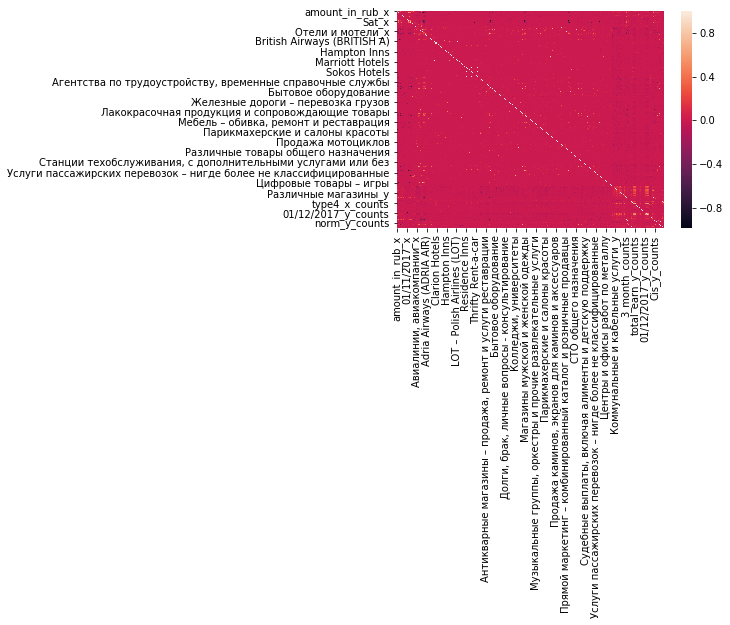

In [726]:
import seaborn as sns
sns.heatmap(x_train1.corr());

# Predictions

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_scaled_test = pd.DataFrame(StandardScaler().fit_transform(x_test), columns=x_test.columns)
X_scaled_train = pd.DataFrame(StandardScaler().fit_transform(x_train), columns=x_train.columns)
x_test1=X_scaled_test
x_train1=X_scaled_train
del x_train1['index']
del x_test1['index']

In [708]:
import xgboost
from sklearn.metrics import roc_auc_score, roc_curve
xgb = xgboost.XGBClassifier(learning_rate=0.01, max_depth=10, n_jobs=-1)
xgb.fit(x_train1_l1, y_train)
y_train_predict = xgb.predict_proba(x_train1_l1)[:, 1]
y_test_predict = xgb.predict_proba(x_test1_l1)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
#roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
#print("Test: ", roc_auc_test)

Train:  0.94


In [709]:
from sklearn.ensemble import AdaBoostClassifier, 
from sklearn.tree import DecisionTreeClassifier
clf_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10, min_samples_leaf=20, max_features=0.8),
                             n_estimators=20, learning_rate=0.03)

clf_ada.fit(x_train1, y_train)
y_pred_ada_test = clf_ada.predict_proba(x_test1)[:, 1]
y_pred_ada_train = clf_ada.predict_proba(x_train1)[:, 1]

roc_auc_train = np.round(roc_auc_score(y_train, y_pred_ada_train), 2)
#roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)

Train:  0.95


In [710]:
from sklearn.ensemble import  GradientBoostingClassifier
clf_gbm = GradientBoostingClassifier(max_depth=12, min_samples_leaf=10, n_estimators=20, learning_rate=0.05, 
                                     subsample=0.8, max_features=0.8, verbose=2)

clf_gbm.fit(x_train1, y_train)
y_pred_gbm_test = clf_gbm.predict_proba(x_test1)[:, 1]
y_pred_gbm_train = clf_gbm.predict_proba(x_train1)[:, 1]

roc_auc_train = np.round(roc_auc_score(y_train, y_pred_gbm_train), 2)
#roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3341           0.0254            7.53s
         2           1.2932           0.0182            7.28s
         3           1.2591           0.0174            6.82s
         4           1.2224           0.0148            6.39s
         5           1.1992           0.0162            6.14s
         6           1.1707           0.0128            5.65s
         7           1.1447           0.0124            5.17s
         8           1.1254           0.0101            4.77s
         9           1.1025           0.0099            4.36s
        10           1.0839           0.0045            3.98s
        11           1.0638           0.0074            3.58s
        12           1.0379           0.0064            3.21s
        13           1.0152           0.0043            2.84s
        14           1.0070           0.0055            2.40s
        15           0.9859           0.0047            2.00s
       

In [711]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=200, max_depth=50, min_samples_leaf=10, max_features=0.8, n_jobs=-1)
clf_rf.fit(x_train1, y_train)
y_pred_RFC = clf_gbm.predict_proba(x_test1)[:, 1]
y_pred_RFC_train = clf_gbm.predict_proba(x_train1)[:, 1]

roc_auc_train = np.round(roc_auc_score(y_train, y_pred_RFC_train), 2)
#roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)

Train:  0.95


In [705]:
from sklearn import svm
svm = svm.SVC()
svm.fit(x_train1, y_train) 

y_pred_svm = clf_gbm.predict_proba(x_test1)[:, 1]
y_pred_svm_train = clf_gbm.predict_proba(x_train1)[:, 1]

roc_auc_train = np.round(roc_auc_score(y_train, y_pred_svm_train), 2)
#roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)

Train:  0.97


In [712]:
from sklearn import svm
svm = svm.SVC(kernel='linear')
svm.fit(x_train1, y_train) 

y_pred_svm = clf_gbm.predict_proba(x_test1)[:, 1]
y_pred_svm_train = clf_gbm.predict_proba(x_train1)[:, 1]

roc_auc_train = np.round(roc_auc_score(y_train, y_pred_svm_train), 2)
#roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)

Train:  0.95


In [728]:
from sklearn import linear_model
lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(x_train1, y_train)


Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [723]:
from sklearn.feature_selection import SelectFromModel
select =SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median')
select.fit(x_train1,y_train)
x_train1_l1=select.transform(x_train1)
x_test1_l1=select.transform(x_test1)
score=LogisticRegression().fit(x_train1_l1,y_train).score(x_train1_l1,y_train)
print(score)

0.7502


In [727]:
from sklearn.feature_selection import RFE
select =RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=450)
rfc= RandomForestClassifier(n_estimators=500)
rfc.fit(x_train1_l1,y_train)

rfc.score(x_train1_l1,y_train)

1.0

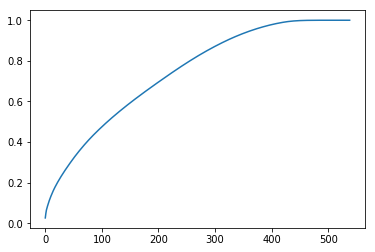

In [713]:
pca = PCA()
pca.fit(x_train1)
cumsum = np.cumsum(pca.explained_variance_ratio_)
cumsum = np.cumsum(pca.explained_variance_ratio_)
#e = pd.DataFrame(pca.components_,columns=x_train1.columns)
plt.plot(cumsum);

In [669]:
y_test_predict

array([0.679955  , 0.80270904, 0.22664922, ..., 0.93753314, 0.80796003,
       0.87948   ], dtype=float32)

In [670]:
rtr=pd.DataFrame(y_test_predict)

In [671]:
sub = pd.DataFrame({
    '_ID_':qqq,
    '_VAL_': y_test_predict
})

In [672]:
sub.to_csv('1.csv',index=False)
sub.head()

,_ID_,_VAL_
0,2,0.679955
199,3,0.802709
295,4,0.226649
453,6,0.939908
702,7,0.652799


In [ ]:
y_hat = model.predict(test.drop(['target_flag','target_sum'],axis=1))
sub = pd.DataFrame({
    '_ID_':test['cl_id'],
    '_VAL_': y_hat
})
sub.to_csv('1.csv',index=False)
sub.head()

In [565]:
sub['_VAL_']=sub.apply(r, axis=1)

In [ ]:
x_train=data_train
x_test=data_test

In [576]:
x_train=x_train.fillna(0)
x_test=x_test.fillna(0)

In [620]:
qqqq=x_train.corr()

In [627]:
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression()
clf_lr.fit(x_train1_l1, y_train)

In [537]:
y_train=y_train.astype(int)

In [666]:
clf_pred = clf_lr.predict(x_test)

In [640]:
clf_lr.score(x_train1_l1,y_train)

0.7502

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

1.0

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
        norm_order=1, prefit=False, threshold='median')

In [632]:
x_train1_l1=select.transform(x_train1)

In [656]:
x_test1_l1=select.transform(x_test1)

In [633]:
x_train.shape

(5000, 541)

In [635]:
x_train1_l1.shape

(5000, 270)

In [589]:
select.fit(x_train1,y_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
  n_features_to_select=450, step=1, verbose=0)

In [592]:
x_train_rfe=select.transform(x_train1)
x_test_rfe=select.transform(x_test1)
score=LogisticRegression().fit(x_train_rfe,y_train).score(x_train_rfe,y_train)
print(score)

0.7738


In [675]:
select.score(x_test,y_test)

0.7195448460508701

In [424]:
x_train_rfe

array([[-0.0667698 ,  0.75802039, -0.93525467, ...,  1.78796391,
        -0.17355283, -0.31619816],
       [ 0.15566702,  0.59445906,  1.33710994, ...,  1.18816551,
         0.54992428,  0.72623215],
       [-0.11340933, -1.04115425, -1.30992793, ..., -0.81116249,
        -1.13015033, -0.88804565],
       ...,
       [ 0.53832919, -0.30512826,  0.4097176 , ..., -0.16138089,
         0.83127649, -0.40554933],
       [-0.16370795, -0.55047026,  0.89385357, ..., -0.31133049,
        -0.6558709 , -0.37576561],
       [ 0.06963037, -0.2233476 , -1.13627414, ..., -0.57124313,
        -0.78448905, -0.69147307]])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

0.7822